### Import Dataset

In [ ]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", DATASET_PATH)

100%|██████████| 612M/612M [00:28<00:00, 22.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


### Import Library

In [ ]:
import os
import cv2
import wandb
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.utils import to_categorical, plot_model

### Init WanDB

In [ ]:
wandb.init(
    project="Traffic Sign Classification",
    name="Experiment on CNN With RGB Image",
    config={
        "learning_rate": 0.001,
        "batch_size": 32,
        "epochs": 50,
        "model": "CNN",
        "optimizer": "Adam"
    }
)

config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Traffic Sign Label Definitions

In [ ]:
CLASS_LABELS = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

### Load Data

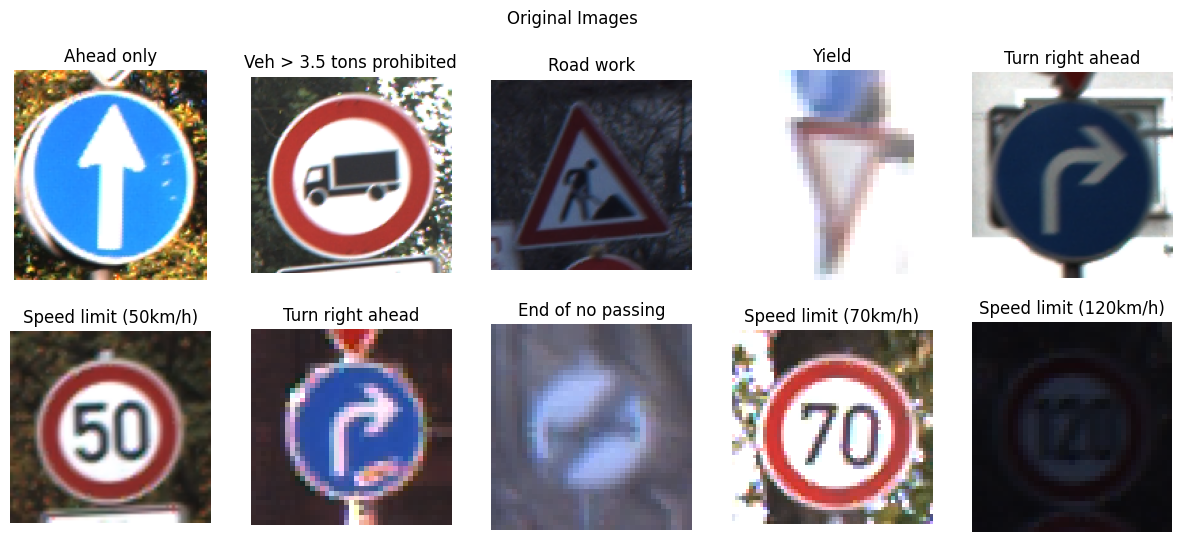

In [ ]:
def _load_images_and_labels(csv_file):
  images, labels = [], csv_file['ClassId'].values
  for path in csv_file['Path']:
      img = cv2.imread(os.path.join(DATASET_PATH, path))
      images.append(img)
  return images, labels

def load_data():
  train_csv = pd.read_csv(os.path.join(DATASET_PATH, "Train.csv"))
  test_csv = pd.read_csv(os.path.join(DATASET_PATH, "Test.csv"))
  meta_csv = pd.read_csv(os.path.join(DATASET_PATH, "Meta.csv"))

  train_images, train_labels = _load_images_and_labels(train_csv)
  test_images, test_labels = _load_images_and_labels(test_csv)
  meta_images, meta_labels = _load_images_and_labels(meta_csv)

  train_images.extend(meta_images)
  train_labels = np.concatenate((train_labels, meta_labels), axis=0)

  train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
  test_images, test_labels = shuffle(test_images, test_labels, random_state=42)

  fig, axes = plt.subplots(2, 5, figsize=(15, 6))
  for i, ax in enumerate(axes.flat):
      ax.imshow(cv2.cvtColor(train_images[i], cv2.COLOR_BGR2RGB))
      ax.set_title(f'{CLASS_LABELS[train_labels[i]]}')
      ax.axis('off')
  plt.suptitle('Original Images')
  plt.show()

  return (train_images, train_labels), (test_images, test_labels)

(train_images, train_labels), (test_images, test_labels) = load_data()

### Preprocessing Data

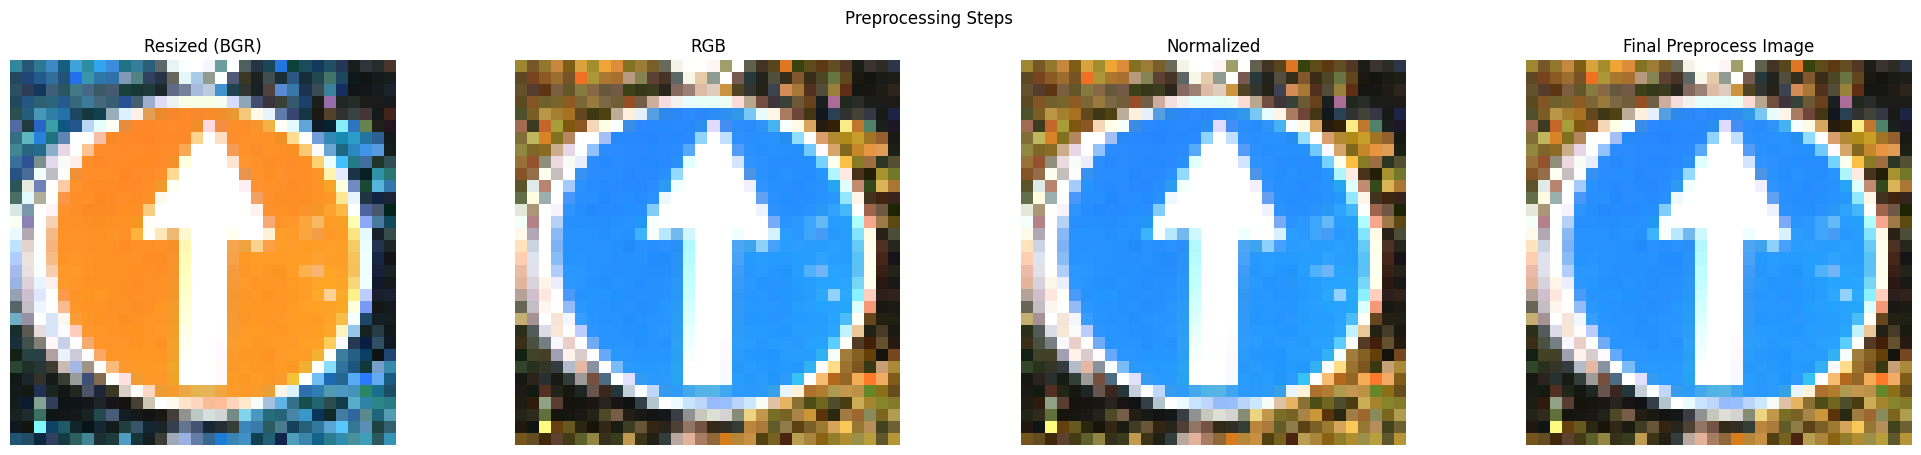

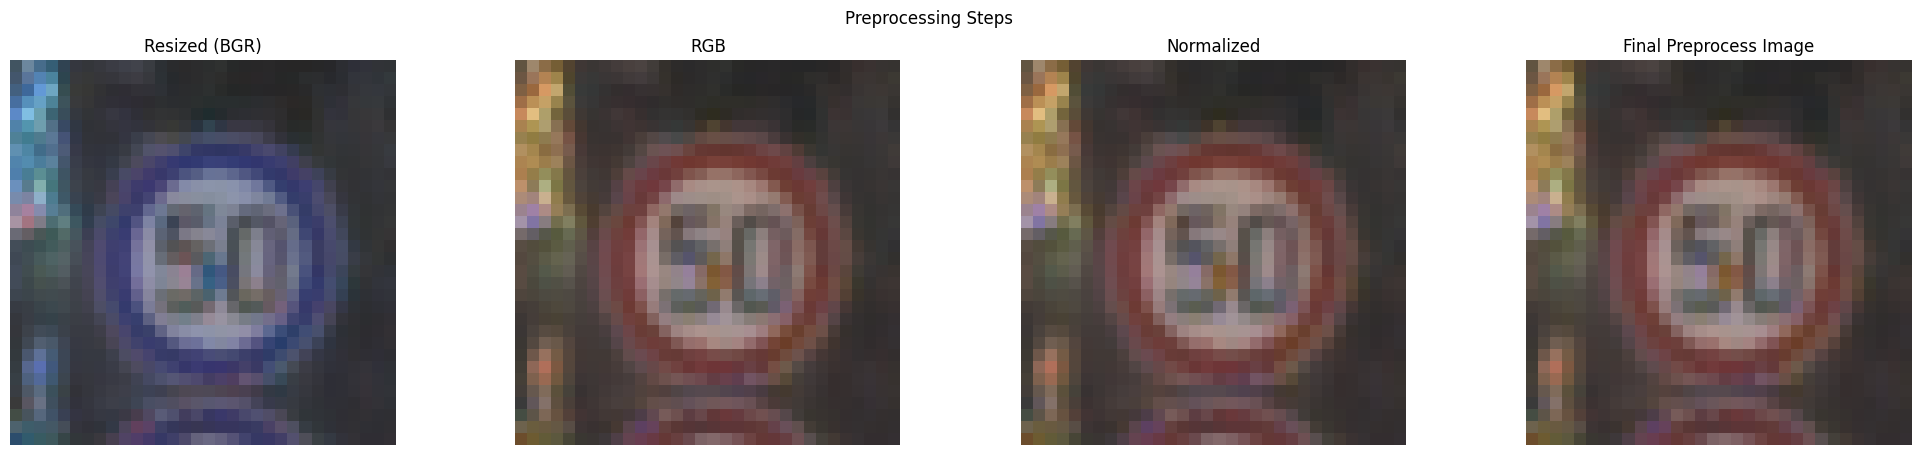

In [ ]:
def _plot_preprocessing_steps(image):
  resized = cv2.resize(image, (32, 32))
  rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
  normalized = rgb / 255.0
  final_preprocessed = normalized.reshape((*normalized.shape, 1))

  fig, axes = plt.subplots(1, 4, figsize=(25, 5))
  steps = [resized, rgb, normalized, final_preprocessed]
  titles = ['Resized (BGR)', 'RGB', 'Normalized', 'Final Preprocess Image']

  for ax, img, title in zip(axes, steps, titles):
      ax.imshow(img if title == 'Resized (BGR)' else img.squeeze())
      ax.set_title(title)
      ax.axis('off')

  plt.suptitle('Preprocessing Steps')
  plt.show()

def _preprocess_images(images):
  processed = []
  for img in images:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (32, 32))
      img = img_to_array(img) / 255.0
      processed.append(img)
  return np.array(processed)

def preprocess_data(images, labels):
  _plot_preprocessing_steps(images[0])
  print()

  images = _preprocess_images(images)
  labels = to_categorical(labels, num_classes=43)

  return images, labels

X_train, y_train = preprocess_data(train_images, train_labels)
X_test, y_test = preprocess_data(test_images, test_labels)

#### Splitting Dataset

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

total_len = len(X_train) + len(X_val) + len(X_test)

print(f"Train dataset: {len(X_train)} ({(len(X_train) / total_len) * 100:.2f}%)")
print(f"Validation dataset: {len(X_val)} ({(len(X_val) / total_len) * 100:.2f}%)")
print(f"Test dataset: {len(X_test)} ({(len(X_test) / total_len) * 100:.2f}%)")

Train dataset: 39252 (75.66%)
Validation dataset: 6315 (12.17%)
Test dataset: 6315 (12.17%)


### Build and Train Model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=config.learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193,067 (754.17 KB)

 Trainable params: 193,067 (754.17 KB)

 Non-trainable params: 0 (0.00 B)

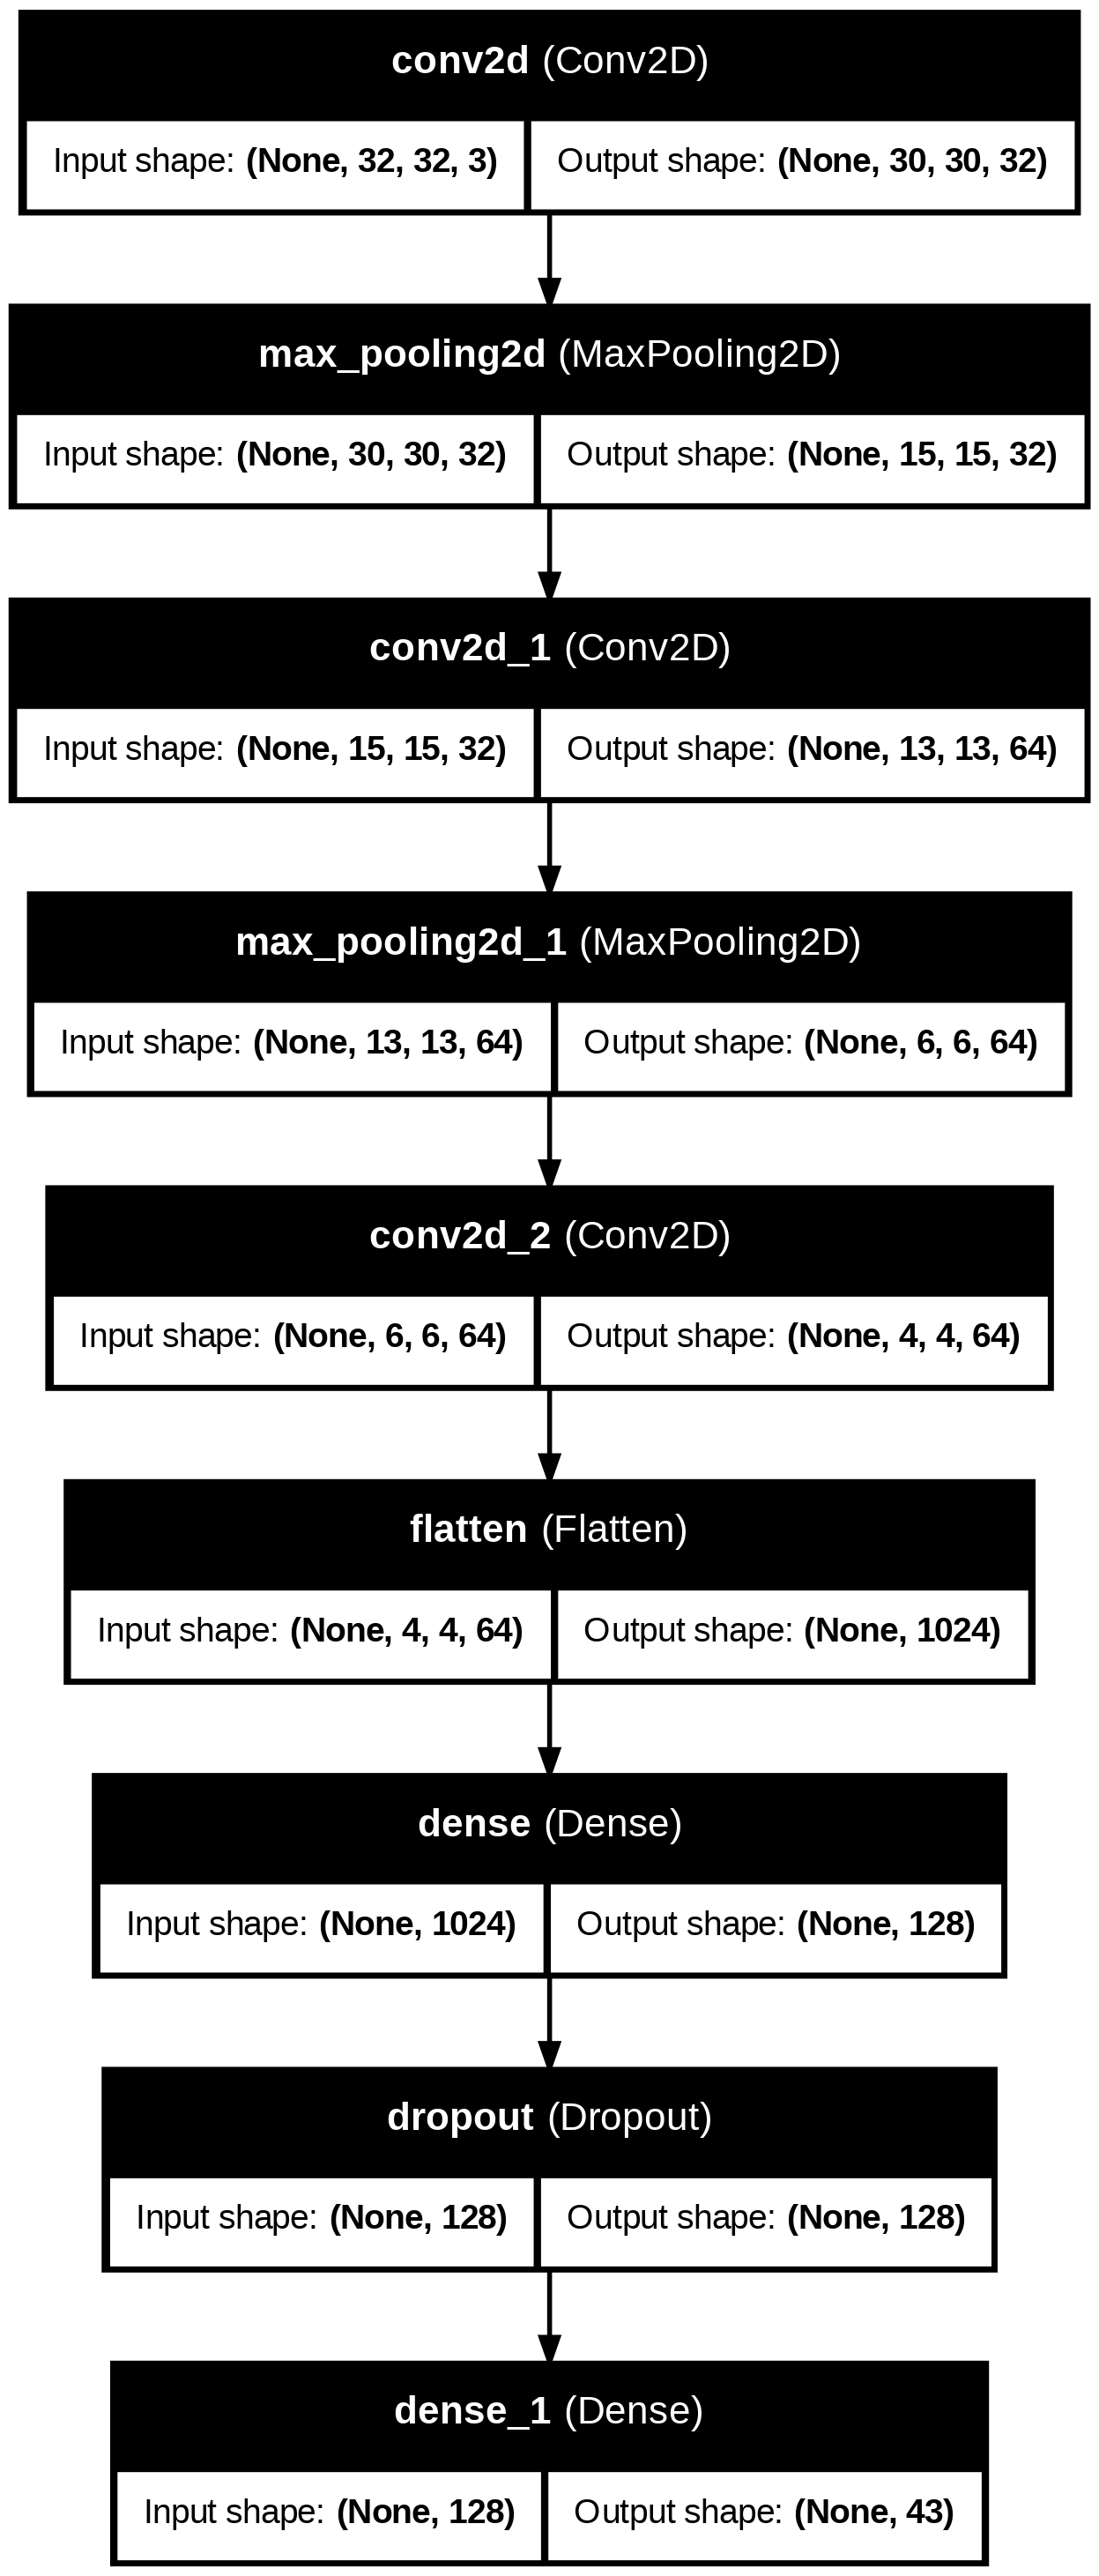

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

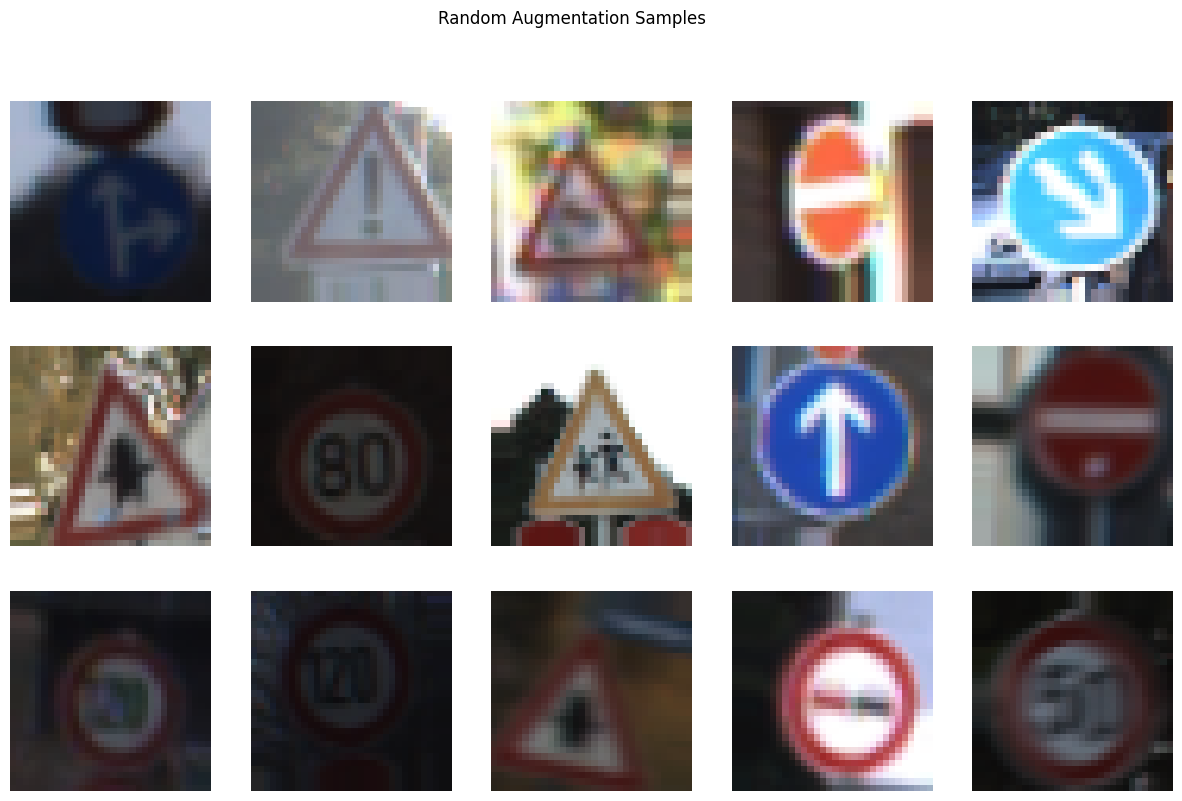

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1227/1227 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.2326 - loss: 2.7939 - val_accuracy: 0.7279 - val_loss: 0.8373
Epoch 2/50
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6511 - loss: 1.0695 - val_accuracy: 0.8410 - val_loss: 0.4855
Epoch 3/50
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.7861 - loss: 0.6520 - val_accuracy: 0.9120 - val_loss: 0.3047
Epoch 4/50
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.8609 - loss: 0.4329 - val_accuracy: 0.9319 - val_loss: 0.2537
Epoch 5/50
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - accuracy: 0.8970 - loss: 0.3187 - val_accuracy: 0.9430 - val_loss: 0.2181
Epoch 6/50
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.9206 - loss: 0.2513 - val_accuracy: 0.9447 - val_loss: 0.2156
Epoch 7/50
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.9358 - loss: 0.2052 - val_accuracy: 0.9458 - val_loss: 0.2247
Epoch 8/50
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.9437 - loss: 0.18

In [ ]:
def _plot_random_augmentations(datagen, images):
  augmented_samples = next(datagen.flow(images, batch_size=15))
  fig, axes = plt.subplots(3, 5, figsize=(15, 9))
  for i, ax in enumerate(axes.flat):
      ax.imshow(augmented_samples[i].squeeze())
      ax.axis('off')
  plt.suptitle('Random Augmentation Samples')
  plt.show()

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

datagen.fit(X_train)
_plot_random_augmentations(datagen, X_train)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=config.batch_size),
    validation_data=(X_val, y_val),
    epochs=config.epochs,
    callbacks=[early_stopping]
)

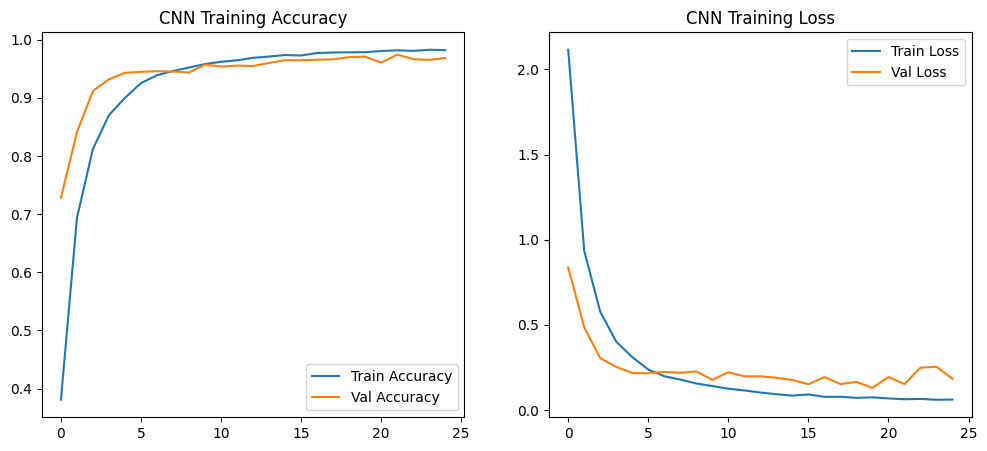

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('CNN Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('CNN Training Loss')

plt.show()

### Evaluate the model using test data

In [ ]:
metrics = model.evaluate(X_test, y_test, verbose=0)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

classification_metrics = {
  'accuracy': accuracy_score(y_true, y_pred),
  'precision': precision_score(y_true, y_pred, average='weighted'),
  'recall': recall_score(y_true, y_pred, average='weighted'),
  'f1_score': f1_score(y_true, y_pred, average='weighted')
}

198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
print(f"💡Test Loss: {metrics[0]}")
print(f"💡Test Accuracy: { metrics[1]}")

💡Test Loss: 0.12270700931549072
💡Test Accuracy: 0.9700712561607361


In [ ]:
print("💡 Classification Metrics:")
for metric, value in classification_metrics.items():
  print(f"{metric}: {value}")

💡 Classification Metrics:
accuracy: 0.9700712589073635
precision: 0.9704983866956899
recall: 0.9700712589073635
f1_score: 0.9695851638607152


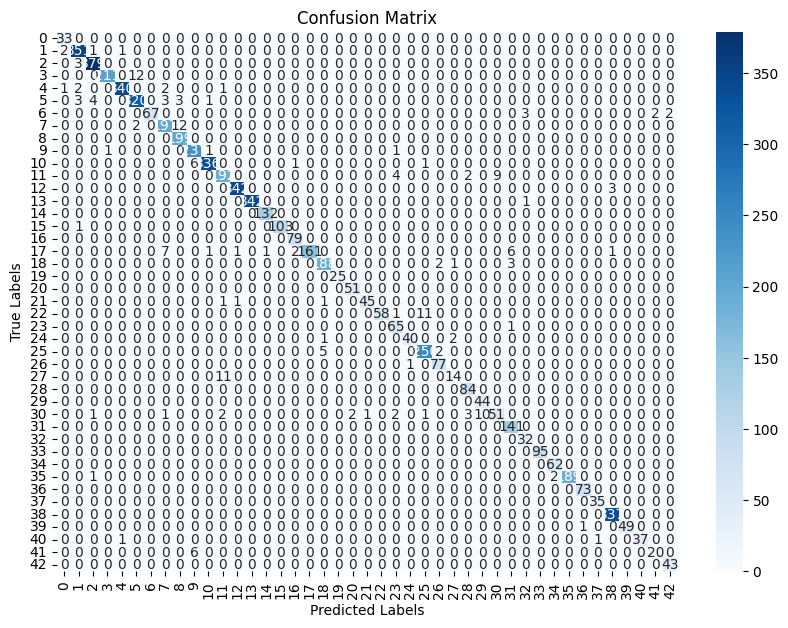

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

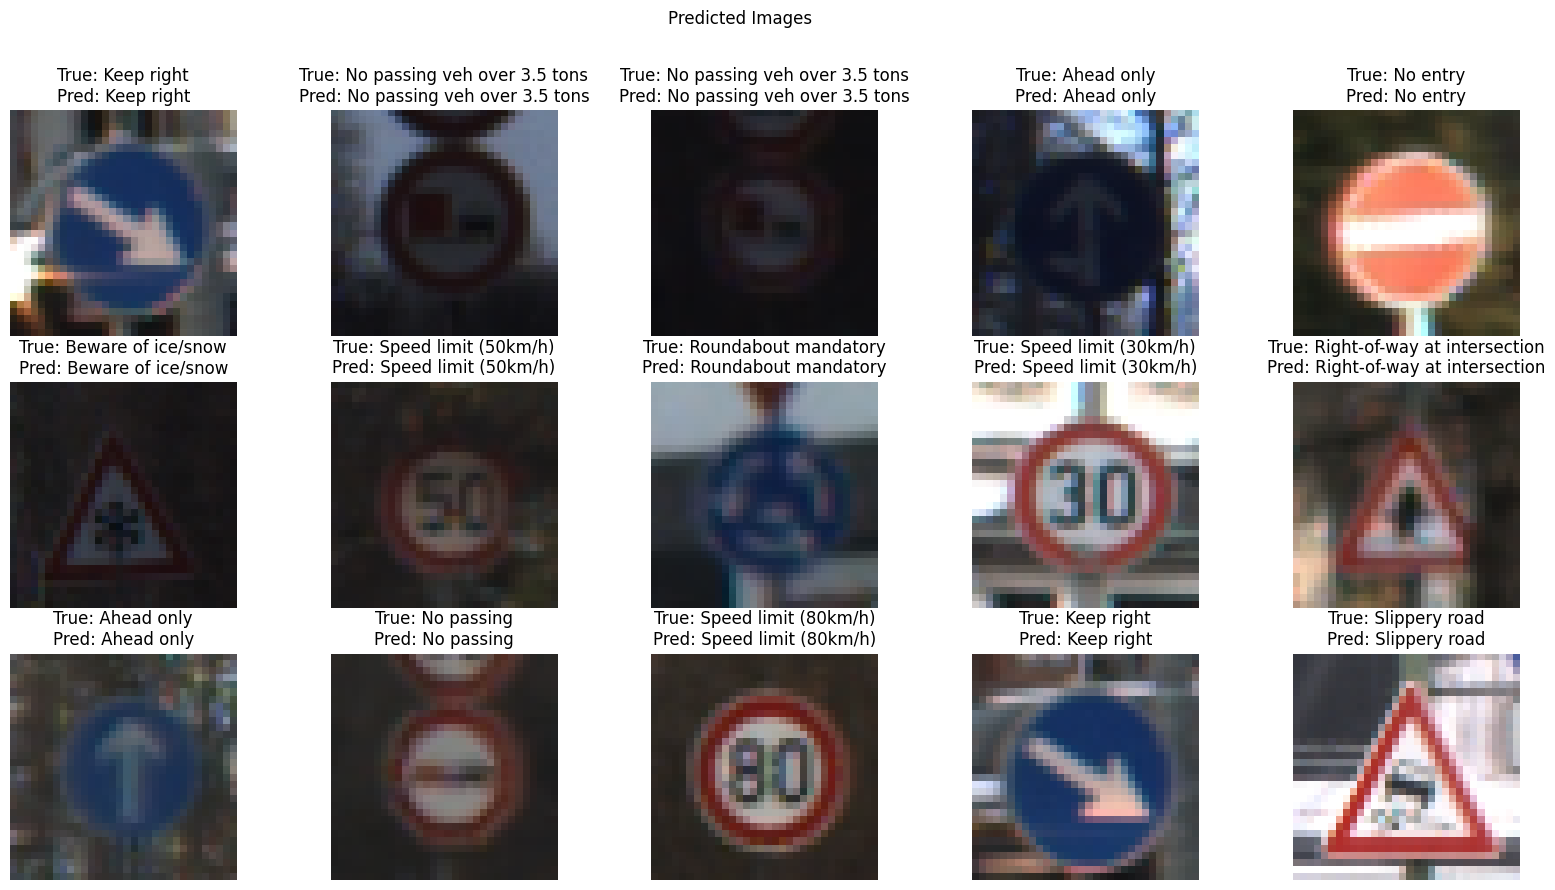

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].squeeze())
    ax.set_title(f"True: {CLASS_LABELS[y_true[i]]}\nPred: {CLASS_LABELS[y_pred[i]]}")
    ax.axis('off')
plt.suptitle('Predicted Images')
plt.show()

### Log metrics and save model to WanDB

In [ ]:
wandb.log({
    'test_loss': metrics[0],
    'test_accuracy': metrics[1],
    'accuracy': classification_metrics['accuracy'],
    'precision': classification_metrics['precision'],
    'recall': classification_metrics['recall'],
    'f1_score': classification_metrics['f1_score']
})

model_path = "cnn_model.keras"
model.save(model_path)
wandb.save(model_path)
wandb.finish()

accuracy,▁
f1_score,▁
precision,▁
recall,▁
test_accuracy,▁
test_loss,▁
accuracy,0.97007
f1_score,0.96959
precision,0.9705
recall,0.97007
test_accuracy,0.97007
